# Training FER models

Using new DFERP dataset, we want to train some CNN and try out some pretrained models in order to achive better results in FER

## Installing and setting up Colab

In [1]:
! pip install tensorflow-addons

# Using SciencePlots
! pip install SciencePlots
! pip install matplotlib==3.5.1
! pip install split-folders

In [2]:
# Imports 

import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import splitfolders

import tensorflow as tf
import tensorflow_addons as tfa

from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D, Rescaling, RandomFlip, RandomRotation, RandomZoom
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

plt.style.use(['science', 'notebook', 'grid'])

In [3]:
# Setup GPU tensorflow

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Setup Datasets

Download the DFERP Dataset and prepare tensorflow dataset API

In [4]:
# Get DFERP dataset

! rm -rf dferp_ds

! cp /content/drive/MyDrive/FER_project/ProcessedData/dferp_ds.zip .
! unzip -q dferp_ds.zip
! mv dferp_ds/train dferp_ds/train_orig
! rm -rf dferp_ds.zip

In [5]:
SEED = 2908

splitfolders.ratio("dferp_ds/train_orig", output="dferp_ds/", seed=SEED, ratio=(.65, .35), move=True)

Copying files: 28954 files [00:04, 6013.57 files/s]


In [6]:
! rm -rf dferp_ds/train_orig

In [7]:
# Create TF dataset
img_height = 48
img_width = 48
batch_size = 128

train_dir = 'dferp_ds/train/'
val_dir = 'dferp_ds/val/'
test_dir = 'dferp_ds/test/'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  label_mode='categorical',
  color_mode='grayscale',
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=SEED)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  label_mode='categorical',
  color_mode='grayscale',
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=SEED)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  label_mode='categorical',
  color_mode='grayscale',
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=SEED)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 18817 files belonging to 7 classes.
Found 10137 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
(128, 48, 48, 1)
(128, 7)
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


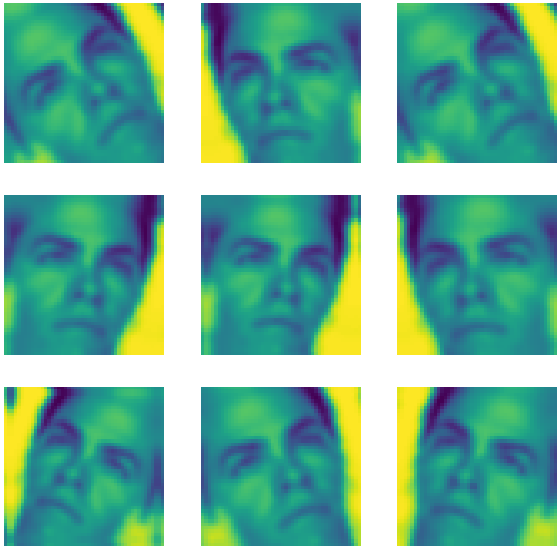

In [9]:
# Normalize the data and do Data Augmentation
AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = Rescaling(1./255)

data_augmentation = Sequential(
  [
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

def prepare(ds, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("float32"))
    plt.axis("off")

## Building the first network architecture

The four initial phases, we try to have features extracted and obtain a verbose feature map.

```
Phase 1

Convolutional2D( Filters: 32, Size: 3x3, Stride: 1, padding: same, Input: 48x48x1)
Activation: ReLU
Convolutional2D( Filters: 64, Size: 3x3, Stride: 1, padding: same)
Activation: ReLU
Batch Normalization
MaxPool2D( Size: 2x2, Stride: None, padding: valid)
Dropout: 0.25

Phase 2

Convolutional2D( Filters: 128, Size: 5x5, Stride: 1, padding: same)
Activation: ReLU
Batch Normalization
MaxPool2D( Size- 2x2, Stride: None, padding: valid)
Dropout: 0.25

Phase 3

Convolutional2D( Filters: 512, Size: 3x3, Stride- 1, Active padding, kernel_regularizer: l2(0.01)
Batch Normalization
Activation: ReLU
MaxPool: Size: 2x2, Stride: None, padding: valid)
Dropout: 0.25

Phase 4

Convolutional2D( Filters: 512, Size: 3x3, Stride- 1, Active padding, kernel_regularizer: l2(0.01)
Batch Normalization
Activation: ReLU
MaxPool: Size: 2x2, Stride: None, padding: valid)
Dropout: 0.25

Phase 5

Flatten

Using this 256 vector space feature map, fully connected layers(FCN or Dense layers) can be used

FCN: Unit- 256
Activation: ReLU
Batch Normalization
Dropout: 0.25

Phase 6

FCN: Units- 512
Activation: ReLU
Batch Normalization
Dropout: 0.25

Phase 7

FCN: Units: 7
Activation: Softmax
```

In [ ]:
custom_model = tf.keras.models.Sequential()
custom_model.add(Convolution2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
custom_model.add(Convolution2D(64, (3,3), padding='same', activation='relu' ))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.25))

custom_model.add(Convolution2D(128,(5,5), padding='same', activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.25))
    
custom_model.add(Convolution2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.25))

custom_model.add(Convolution2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Dropout(0.25))

custom_model.add(Flatten()) 
custom_model.add(Dense(256,activation = 'relu'))
custom_model.add(BatchNormalization())
custom_model.add(Dropout(0.25))
    
custom_model.add(Dense(512,activation = 'relu'))
custom_model.add(BatchNormalization())
custom_model.add(Dropout(0.25))

custom_model.add(Dense(7, activation='softmax'))

In [ ]:
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
custom_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
  loss='categorical_crossentropy',
  metrics=[tfa.metrics.FBetaScore(beta=1.0, num_classes=num_classes, average='macro'), 'acc'])

custom_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=[tfa.metrics.FBetaScore(beta=1.0, num_classes=num_classes, average='macro'), 'accuracy']
  )

filepath = os.path.join('drive/MyDrive/FER_project/Models/custom_model/', 'Model.{epoch:02d}-{val_fbeta_score:.4f}.hdf5')

checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, verbose=0, mode='auto')

In [ ]:
%%time
history = custom_model.fit(train_ds,
                    epochs=300,
                    verbose=1, 
                    validation_data=val_ds, 
                    callbacks=[checkpointer, reduce_lr, early_stop])

Epoch 1/300
148/148 [==============================] - ETA: 0s - loss: 9.5125 - fbeta_score: 0.1640 - accuracy: 0.1819
Epoch 1: val_loss improved from inf to 8.80935, saving model to drive/MyDrive/FER_project/Models/custom_model/Model.01-0.0553.hdf5
148/148 [==============================] - 42s 169ms/step - loss: 9.5125 - fbeta_score: 0.1640 - accuracy: 0.1819 - val_loss: 8.8094 - val_fbeta_score: 0.0553 - val_accuracy: 0.1747 - lr: 1.0000e-04
Epoch 2/300
147/148 [============================>.] - ETA: 0s - loss: 8.8629 - fbeta_score: 0.1803 - accuracy: 0.2079
Epoch 2: val_loss improved from 8.80935 to 8.46367, saving model to drive/MyDrive/FER_project/Models/custom_model/Model.02-0.0574.hdf5
148/148 [==============================] - 25s 163ms/step - loss: 8.8628 - fbeta_score: 0.1803 - accuracy: 0.2078 - val_loss: 8.4637 - val_fbeta_score: 0.0574 - val_accuracy: 0.2514 - lr: 1.0000e-04
Epoch 3/300
147/148 [============================>.] - ETA: 0s - loss: 8.3078 - fbeta_score: 0.190

## Evaluations
Once the model is trained, we run it on test data and see how it performs. The below code gives us the loss and the accuracy of the network when run on test data

In [ ]:
custom_model = tf.keras.models.load_model('drive/MyDrive/FER_project/Models/custom_model/Model.126-0.6333.hdf5')

score = custom_model.evaluate(train_ds)
print('--------- Training evaluation ---------')
print('Evaluation loss: ', score[0])
print('Evaluation fbetea: ', score[1])
print('Evaluation accuracy: ', score[2])

score = custom_model.evaluate(val_ds)
print('--------- Validation evaluation ---------')
print('Evaluation loss: ', score[0])
print('Evaluation fbetea: ', score[1])
print('Evaluation accuracy: ', score[2])

score = custom_model.evaluate(test_ds)
print('--------- Test evaluation ---------')
print('Evaluation loss: ', score[0])
print('Evaluation fbetea: ', score[1])
print('Evaluation accuracy: ', score[2])

148/148 [==============================] - 17s 108ms/step - loss: 0.8434 - fbeta_score: 0.7795 - accuracy: 0.7898
--------- Training evaluation ---------
Evaluation loss:  0.843438446521759
Evaluation fbetea:  0.7794756889343262
Evaluation accuracy:  0.7897645831108093
80/80 [==============================] - 8s 81ms/step - loss: 1.2499 - fbeta_score: 0.6333 - accuracy: 0.6654
--------- Validation evaluation ---------
Evaluation loss:  1.249886155128479
Evaluation fbetea:  0.6333237886428833
Evaluation accuracy:  0.6653842329978943
57/57 [==============================] - 5s 78ms/step - loss: 1.2730 - fbeta_score: 0.6212 - accuracy: 0.6521
--------- Test evaluation ---------
Evaluation loss:  1.2730439901351929
Evaluation fbetea:  0.6212338209152222
Evaluation accuracy:  0.6521314978599548


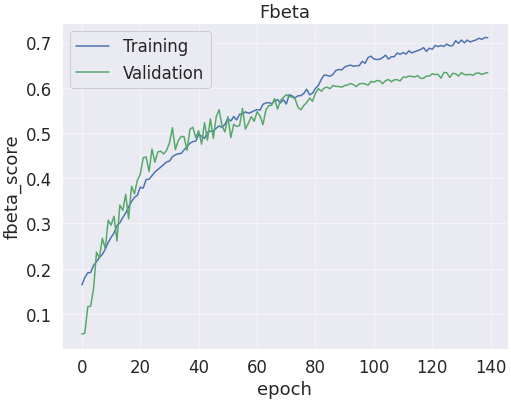

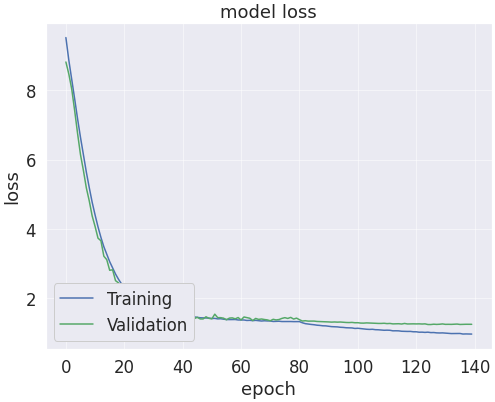

In [ ]:
# summarize history for fbeta
plt.figure(figsize=(10, 10))
plt.plot(history.history['fbeta_score'], color='b', label='Training')
plt.plot(history.history['val_fbeta_score'], color='g', label='Validation')
plt.title('Fbeta')
plt.ylabel('fbeta_score')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10, 10))
# summarize history for loss
plt.plot(history.history['loss'], color='b', label='Training')
plt.plot(history.history['val_loss'], color='g', label='Validation')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower left')
plt.show()

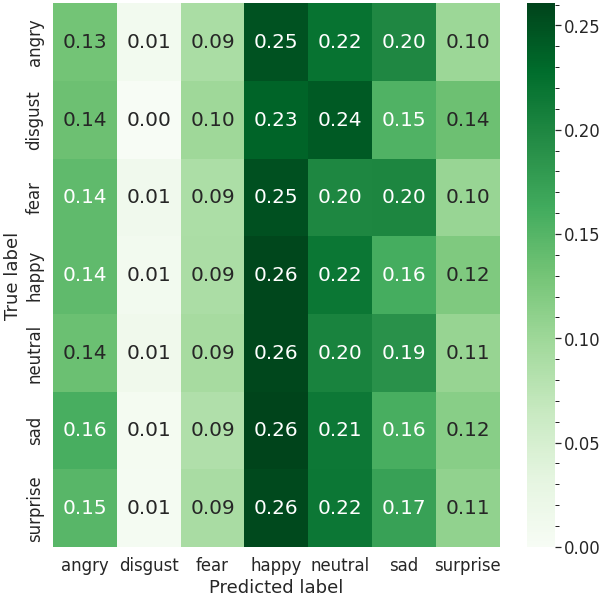

In [ ]:
X = np.concatenate([x for x, y in test_ds], axis=0)
y = np.concatenate([y for x, y in test_ds], axis=0)

y_pred = np.asarray([np.argmax(i) for i in custom_model.predict(X)])
y_true = np.asarray([np.argmax(i) for i in y])

cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5) 
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                    cmap="Greens", yticklabels=class_names, xticklabels=class_names, vmin=0, vmax=np.max(cm_normalised), 
                    fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label');

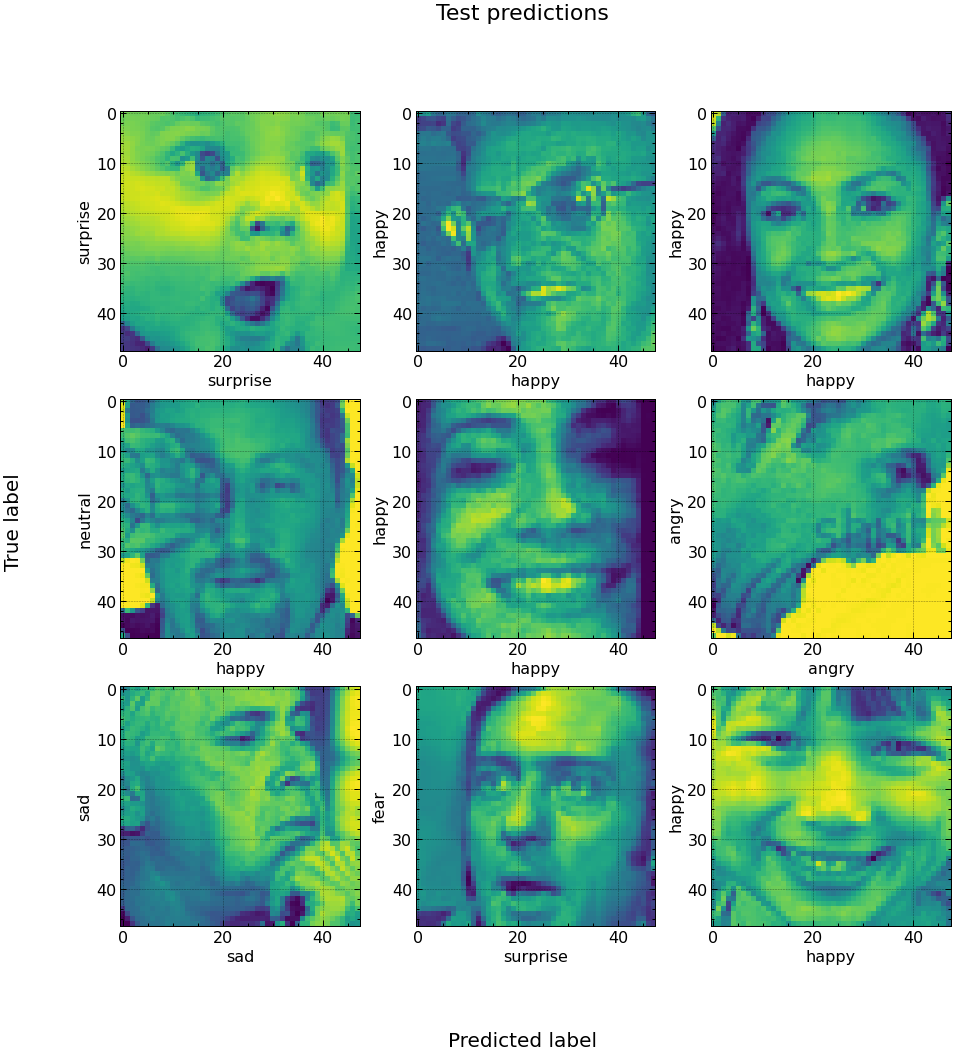

In [ ]:
# test_ds = test_ds.unbatch()
fig = plt.figure(figsize=(15, 15))
i = 0
for image, y_true in test_ds.take(9):
  y_pred = np.asarray([np.argmax(i) for i in custom_model.predict(tf.expand_dims(image, axis=0))])[0]
  ax = fig.add_subplot(3, 3, i + 1)
  ax.imshow(image.numpy())
  ax.set_xlabel(class_names[y_pred])
  ax.set_ylabel(class_names[np.argmax(y_true, axis=0)])
  i += 1

fig.suptitle('Test predictions', fontsize=22)
fig.supxlabel('Predicted label', fontsize=20)
fig.supylabel('True label', fontsize=20)
plt.show()